In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.filterwarnings("ignore")

## Combining Results 

In [2]:
fingerprints = pd.read_csv('resources/descriptors_output.csv')

In [3]:
fingerprints.rename({'Name': 'molecule_chembl_id'}, axis = 1, inplace = True)

In [4]:
bioactivity = pd.read_csv('output/bioactivity.csv')
bioactivity = bioactivity[['molecule_chembl_id', 'pIC50']]

In [5]:
cleaned_df = pd.merge(fingerprints, bioactivity, on = 'molecule_chembl_id')

In [6]:
cleaned_df.head(2)

,molecule_chembl_id,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,pIC50
0,CHEMBL1077291,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7.823909
1,CHEMBL1083839,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5.000000


In [7]:
cleaned_df.drop('molecule_chembl_id', axis = 1, inplace = True)

## Input Features 

* There data set condatins 880 inputs and one variable (pIC50). However, not are inputs are created equal - for instance, if a input does not have much variation accross IDs - we need to remove it, as it would be unnessary noise for 

### Principle Component Analysis 

In [8]:
x = cleaned_df.iloc[:, :-1]

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 0.95)
pca.fit(x)
reduced = pca.transform(x)

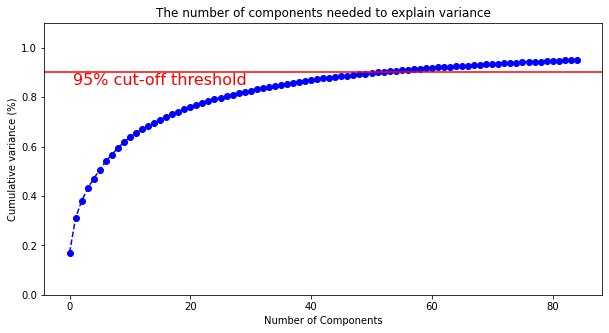

In [10]:
plt.figure(figsize=(10, 5))

y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot( y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.90, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)
plt.savefig('Output/figures/PCA_Analysis.pdf')
plt.show()

In [11]:
reduced_df = pd.DataFrame(reduced)

In [12]:
reduced_df['pIC50'] = cleaned_df['pIC50']

## Machine Learning Models 

In [13]:
X = reduced_df.iloc[:, :-1]
Y = reduced_df.iloc[:, -1]

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 1)

### 1.1 Linear Regression

In [16]:
from sklearn.linear_model import LinearRegression

In [17]:
def lr(X_train, Y_train, X_test, Y_test):
    model = LinearRegression()
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    mse = mean_squared_error(Y_test, Y_pred)
    return mse, Y_test, Y_pred

In [18]:
mse, Y_test_lin, Y_pred_lin = lr(X_train, Y_train, X_test, Y_test)

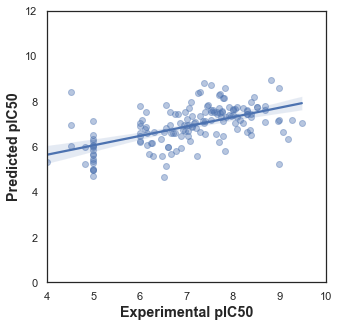

In [19]:
sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(Y_test_lin, Y_pred_lin, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(4, 10)
ax.set_ylim(0, 12)
ax.figure.set_size_inches(5, 5)
plt.savefig('Output/figures/LinearRegression.pdf')
plt.show()

In [20]:
r2_score(Y_test_lin, Y_pred_lin)

0.2657303542335476

### 1.2 Random Forest

In [21]:
def RandomForest(X_train, Y_train, X_test, Y_test, min_sample, max_depth, bootstrap):
    model = RandomForestRegressor(min_samples_leaf = min_sample, max_depth= max_depth, bootstrap = bootstrap)
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    pred = model.predict(X_train)
    mse = mean_squared_error(Y_test, Y_pred)
    
    # Overfitting 
    mse_overfit_check = mean_squared_error(pred, Y_train)
    
    return mse, mse_overfit_check

In [22]:
mse, mse_overfit_check = RandomForest(X_train, Y_train, X_test, Y_test, min_sample = 2, max_depth = 10, bootstrap = True)

### Hyper Optimization of Random Forest

In [23]:
hyper_optimize = []

for i in [2, 4, 6, 8, 10]:
    for x in [2, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:
            mse, mse_overfit_check = RandomForest(X_train, Y_train, X_test, Y_test, min_sample = i, max_depth = x, bootstrap = True)
            hyper_optimize.append([i, x, mse, mse_overfit_check])

df_hyper = pd.DataFrame(hyper_optimize, columns = ['min_sample', 'depth', 'mse', 'mse_overfit_check'])

In [24]:
df_hyper.sort_values(by = 'mse').head()

,min_sample,depth,mse,mse_overfit_check
4,2,40,0.833295,0.149624
15,4,40,0.839797,0.216050
2,2,20,0.852279,0.149944
5,2,50,0.855260,0.156567
21,4,100,0.856019,0.215247


 Based on our hyperoptimization tests, a min_sample of 2 and max_depth of 4 has the lowest mse. Further, the mse and the mse of the overfit check are signifcantly different from each other. This suggests that the model does not suffer from overfitting.

In [25]:
def RandomForest_optimized(X_train, Y_train, X_test, Y_test, min_sample, max_depth, bootstrap):
    model = RandomForestRegressor(min_samples_leaf = min_sample, max_depth= max_depth, bootstrap = bootstrap)
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    pred = model.predict(X_train)
    mse = mean_squared_error(Y_test, Y_pred)

    return Y_pred, Y_test

In [26]:
Y_test_final, Y_Pred_final = RandomForest_optimized(X_train, Y_train, X_test, Y_test, min_sample = 2, max_depth = 90, bootstrap = True)

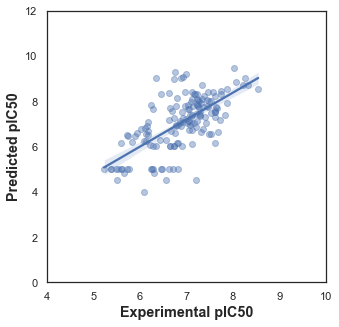

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(Y_test_final, Y_Pred_final, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(4, 10)
ax.set_ylim(0, 12)
ax.figure.set_size_inches(5, 5)
plt.savefig('Output/figures/RandomForest.pdf')
plt.show()

In [28]:
r2_score(Y_Pred_final, Y_test_final)

0.4065705300104535